In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from itertools import product

import os

In [2]:
df = pd.read_csv('./res/train_df.csv')
image = cv2.imread('./res/train_imgs/001-1-1-01-Z17_A-0000001.jpg', cv2.COLOR_BGR2RGB)
inputs = tf.expand_dims(image, 0)

In [3]:
# plt.imshow(image)
# plt.axis('off')
# plt.show()

In [4]:
df['x_min'] = df.iloc[:, 1:49:2].apply(lambda x: int(min(x)), axis=1)
df['x_max'] = df.iloc[:, 1:49:2].apply(lambda x: int(max(x)), axis=1)
df['y_min'] = df.iloc[:, 2:49:2].apply(lambda x: int(min(x)), axis=1)
df['y_max'] = df.iloc[:, 2:49:2].apply(lambda x: int(max(x)), axis=1)

# Faster R-CNN

## backbone

### ResNet

### VGG

In [5]:
def get_base(img_size, model='vgg'):
    if model=='vgg':
        base_model = tf.keras.applications.VGG16(include_top=False, input_shape=img_size)
    elif model == 'resnet':
        pass
    else:
        raise Exception('vgg, resnet')
        
    base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=img_size)
    feature_extractor = base_model.get_layer("block5_conv3")
    base_model = tf.keras.models.Model(inputs=base_model.input, outputs=feature_extractor.output)
    return base_model

## Region Proposal Network

### Image resize

In [6]:
df_new = df.copy()

In [7]:
Ry = 0.4
Rx = 0.4
size = (432, 768)

df_new.iloc[:, 1:49:2] = df_new.iloc[:, 1:49:2] * Rx
df_new.iloc[:, 2:49:2] = df_new.iloc[:, 2:49:2] * Ry

In [8]:
df_new['x_min'] = df_new.iloc[:, 1:49:2].apply(lambda x: int(min(x)), axis=1)
df_new['x_max'] = df_new.iloc[:, 1:49:2].apply(lambda x: int(max(x)), axis=1)
df_new['y_min'] = df_new.iloc[:, 2:49:2].apply(lambda x: int(min(x)), axis=1)
df_new['y_max'] = df_new.iloc[:, 2:49:2].apply(lambda x: int(max(x)), axis=1)

In [9]:
image = np.copy(cv2.resize(image, size[::-1]))
inputs = tf.expand_dims(image, 0)
image.shape

(432, 768, 3)

### Ground Truth Generating 

In [10]:
df_new['ratio'] = df_new.apply(lambda x: 'w' if x['x_max'] - x['x_min'] > x['y_max'] - x['y_min'] else 'h', axis=1)
df_new['x_min'] = df_new.apply(lambda x: x['x_min'] - (x['x_max'] - x['x_min'])*.08 if x['ratio'] == 'h' else x['x_min'], axis=1)
df_new['x_max'] = df_new.apply(lambda x: x['x_max'] + (x['x_max'] - x['x_min'])*.08 if x['ratio'] == 'h' else x['x_max'], axis=1)
df_new['y_min'] = df_new.apply(lambda x: x['y_min'] - (x['y_max'] - x['y_min'])*.08 if x['ratio'] == 'w' else x['y_min'], axis=1)
df_new['y_max'] = df_new.apply(lambda x: x['y_max'] + (x['y_max'] - x['y_min'])*.08 if x['ratio'] == 'w' else x['y_max'], axis=1)

In [11]:
ground_truth = df_new.iloc[:,:1].copy() 
ground_truth['x_min'] = df_new['x_min'] - (df_new['x_max'] - df_new['x_min'])*.05
ground_truth['x_max'] = df_new['x_max'] + (df_new['x_max'] - df_new['x_min'])*.05
ground_truth['y_min'] = df_new['y_min'] - (df_new['y_max'] - df_new['y_min'])*.05
ground_truth['y_max'] = df_new['y_max'] + (df_new['y_max'] - df_new['y_min'])*.05

In [12]:
ground_truth['x_min'] = df_new['x_min'] - (df_new['x_max'] - df_new['x_min'])*.05
ground_truth['x_max'] = df_new['x_max'] + (df_new['x_max'] - df_new['x_min'])*.05
ground_truth['y_min'] = df_new['y_min'] - (df_new['y_max'] - df_new['y_min'])*.05
ground_truth['y_max'] = df_new['y_max'] + (df_new['y_max'] - df_new['y_min'])*.05

In [13]:
ground_truth['w'] = ground_truth['x_max'] - ground_truth['x_min']
ground_truth['h'] = ground_truth['y_max'] - ground_truth['y_min']
ground_truth['x'] = ground_truth['w']/2 + ground_truth['x_min']
ground_truth['y'] = ground_truth['h']/2 + ground_truth['y_min']

In [14]:
GT = np.array(ground_truth[['x', 'y', 'w', 'h']])

In [15]:
print(f'min : {int(np.min(np.sqrt(GT[:, 2] * GT[:, 3])))}')
print(f'mean - {3} std : {int(np.mean(np.sqrt(GT[:, 2] * GT[:, 3])) - 3*np.std(np.sqrt(GT[:, 2] * GT[:, 3])))}')
print(f'mean - {2.5} std : {int(np.mean(np.sqrt(GT[:, 2] * GT[:, 3])) - 2.5*np.std(np.sqrt(GT[:, 2] * GT[:, 3])))}')
print(f'mean - {2} std : {int(np.mean(np.sqrt(GT[:, 2] * GT[:, 3])) - 2*np.std(np.sqrt(GT[:, 2] * GT[:, 3])))}')
print(f'mean : {int(np.mean(np.sqrt(GT[:, 2] * GT[:, 3])))}')
print(f'mean + {2} std : {int(np.mean(np.sqrt(GT[:, 2] * GT[:, 3])) + 2*np.std(np.sqrt(GT[:, 2] * GT[:, 3])))}')
print(f'mean - {2.5} std : {int(np.mean(np.sqrt(GT[:, 2] * GT[:, 3])) + 2.5*np.std(np.sqrt(GT[:, 2] * GT[:, 3])))}')
print(f'mean + {3} std : {int(np.mean(np.sqrt(GT[:, 2] * GT[:, 3])) + 3*np.std(np.sqrt(GT[:, 2] * GT[:, 3])))}')
print(f'max : {int(np.max(np.sqrt(GT[:, 2] * GT[:, 3])))}')

min : 82
mean - 3 std : 69
mean - 2.5 std : 85
mean - 2 std : 102
mean : 169
mean + 2 std : 235
mean - 2.5 std : 252
mean + 3 std : 269
max : 292


In [16]:
# h가 w보다 큰 경우 h/w 비율의 평균
GT_h = GT[(GT[:, 2]/GT[:, 3] < .5)]
print('비율의 평균 :', np.mean(GT_h[:, 3] / GT_h[:, 2]))
print(f'w, h 에 곱해줄 비율 : w = {1/np.sqrt(3)}, h = {np.sqrt(3)}')
print(f'적용한 비율 : h/w = {np.sqrt(3) / (1/np.sqrt(3))}')

비율의 평균 : 2.7885240734765593
w, h 에 곱해줄 비율 : w = 0.5773502691896258, h = 1.7320508075688772
적용한 비율 : h/w = 2.9999999999999996


In [17]:
# w가 h보다 큰 경우 w/h 비율의 평균
GT_w = GT[(GT[:, 2]/GT[:, 3] > 1.5)]
print('비율의 평균 :', np.mean(GT_w[:, 2] / GT_w[:, 3]))
print(f'w, h 에 곱해줄 비율 : w = {np.sqrt(3.5)}, h = {1/np.sqrt(2)}')
print(f'적용한 비율 : w/h = {np.sqrt(3.5) / (1/np.sqrt(2))}')

비율의 평균 : 2.414342798214118
w, h 에 곱해줄 비율 : w = 1.8708286933869707, h = 0.7071067811865475
적용한 비율 : w/h = 2.6457513110645907


### Anchor boxes

In [18]:
def anchor_box_generator(x, y):
    scales = [85, 169, 252]
#     ratio = [(1/np.sqrt(2), np.sqrt(2)), (1, 1), (np.sqrt(2), 1/np.sqrt(2))]
    ratio = [(1/np.sqrt(3), np.sqrt(3)), (1, 1), (np.sqrt(3), 1/np.sqrt(3))]
    anchor_boxes = []
    for scale in scales:
        for w, h  in ratio:
            w *= scale
            h *= scale
            
            anchor_boxes.append([x, y, w, h])
    return anchor_boxes

In [19]:
def Anchor_Boxes(img_shape, model='vgg'):
    '''
    input
    img_shape : image shape
    output 
    numpy array shape (w * h * 9, 4)
    '''
    if model == 'vgg':
        ratio = 2**4
        
    w=image.shape[1]//ratio
    h=image.shape[0]//ratio
    
    anchor_boxes = []
    for x in range(image.shape[1]//w//2, image.shape[1], image.shape[1]//w):
        for y in range(image.shape[0]//h//2, image.shape[0], image.shape[0]//h):
            anchor_boxes.append(anchor_box_generator(x, y))
    return np.array(anchor_boxes).reshape(-1, 4)

In [20]:
anchor_boxes = Anchor_Boxes(img_shape=image.shape, model='vgg')
len(anchor_boxes)

11664

In [21]:
ratio = 2**4

w=image.shape[1]//ratio
h=image.shape[0]//ratio
img_ = np.copy(image)

ground_truth_row = ground_truth.iloc[0]
x1 = int(ground_truth_row['x_min'])
x2 = int(ground_truth_row['x_max'])
y1 = int(ground_truth_row['y_min'])
y2 = int(ground_truth_row['y_max'])
# cv2.rectangle(img_, (x1, y1), (x2, y2), (0, 0, 0), thickness=2)

# plt.figure(figsize=(10, 10))
# for x in range(img_.shape[1]//w//2, img_.shape[1], img_.shape[1]//w):
#     for y in range(img_.shape[0]//h//2, img_.shape[0], img_.shape[0]//h):
#             cv2.circle(img_, (x, y), radius=1, color=(255, 0, 0), thickness=2)
            
# plt.imshow(img_)
# plt.axis('off')
# plt.show()

### IoU

In [22]:
def IoU(box1, anchor_boxes):
    '''
    anchor ver
    inputs
    box1 : ground truth box
    anchor_boxes : anchor boxes
    '''
    broadcast = len(anchor_boxes)
    
    box1_area = box1[2] * box1[3]
    box2_area = anchor_boxes[:,2] * anchor_boxes[:,3]
    
    x1 = np.max([np.broadcast_to(box1[0] - box1[2]/2, broadcast), anchor_boxes[:, 0] - anchor_boxes[:, 2]/2], axis=0)
    x2 = np.min([np.broadcast_to(box1[0] + box1[2]/2, broadcast), anchor_boxes[:, 0] + anchor_boxes[:, 2]/2], axis=0)
    
    y1 = np.max([np.broadcast_to(box1[1] - box1[3]/2, broadcast), anchor_boxes[:, 1] - anchor_boxes[:, 3]/2], axis=0)
    y2 = np.min([np.broadcast_to(box1[1] + box1[3]/2, broadcast), anchor_boxes[:, 1] + anchor_boxes[:, 3]/2], axis=0)
    
    h = np.max([np.broadcast_to(0.0, broadcast), y2 - y1 + 1], axis=0)
    w = np.max([np.broadcast_to(0.0, broadcast), x2 - x1 + 1], axis=0)
    
    intersect = h * w
    union = np.broadcast_to(box1_area, broadcast) + box2_area - intersect
    return intersect / union 

In [23]:
def anchor_to_coordinate(box):    
    x1 = box[0] - box[2]/2
    x2 = box[0] + box[2]/2
    y1 = box[1] - box[3]/2
    y2 = box[1] + box[3]/2
    return (x1, x2, y1, y2)

In [24]:
ground_truth_row = ground_truth.iloc[0]

img_ = cv2.imread(f'./res/train_imgs/{ground_truth_row["image"]}', cv2.COLOR_BGR2RGB)
img_ = cv2.resize(img_, size[::-1])

max_output_size = 5
colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(max_output_size)}

x1 = int(ground_truth_row['x_min'])
x2 = int(ground_truth_row['x_max'])
y1 = int(ground_truth_row['y_min'])
y2 = int(ground_truth_row['y_max'])
cv2.rectangle(img_, (x1, y1), (x2, y2), (255, 0, 0), thickness=2)

gt = ground_truth_row[['x', 'y', 'w', 'h']]
ious = IoU(gt, anchor_boxes)
print(np.sum(ious>0.6))

selected_indices = tf.image.non_max_suppression(anchor_boxes, ious, max_output_size=max_output_size, score_threshold=0.01)
anchors = tf.gather(anchor_boxes, selected_indices)
print(IoU(gt, anchors))
print(gt)

for i, anchor_box in enumerate(anchors):
    anchor_box = anchor_to_coordinate(anchor_box.numpy())
    cv2.rectangle(
        img_, 
        (int(anchor_box[0]), int(anchor_box[2])), (int(anchor_box[1]), int(anchor_box[3])), 
        colors.get(i), 
        thickness=1
    )
    
# fig, ax = plt.subplots(dpi=200)
# ax.imshow(img_)
# ax.axis('off')
# plt.show()

12
tf.Tensor([0.71058913 0.71058913 0.62037202 0.54816159 0.48211257], shape=(5,), dtype=float64)
x    417.7272
y       230.5
w    91.09584
h       229.9
Name: 0, dtype: object


### Label Generating

In [25]:
def label_generator(GT, anchor_boxes):
    cls_label = -np.ones(shape=(len(GT), anchor_boxes.shape[0]))
    pos_iou_threshold = 0.65
    neg_iou_threshold = 0.3
    n_sample = 128
    pos_ratio = 0.5
    n_pos = int(pos_ratio * n_sample)
    
    for i in tqdm(range(len(GT))):
        ious = np.apply_along_axis(IoU, 0, GT[i], anchor_boxes=anchor_boxes)
        cls_label[i][ious >= pos_iou_threshold] = 1
        cls_label[i][ious < neg_iou_threshold] = 0
        cls_label[i][np.argmax(ious)] = 1

        pos_index = np.where(cls_label[i] == 1)[0]
        if len(pos_index) > n_pos:
            disable_index = np.random.choice(
                pos_index,
                size = (len(pos_index) - n_pos),
                replace=False
            )
            cls_label[i][disable_index] = -1

        n_neg = n_sample - np.sum(cls_label[i] == 1)
        neg_index = np.where(cls_label[i] == 0)[0]
        if len(neg_index) > n_neg:
            disable_index = np.random.choice(
                neg_index, 
                size = (len(neg_index) - n_neg),             
                replace = False
            )
            cls_label[i][disable_index] = -1
            
    reg_label = np.zeros(shape=(len(GT), anchor_boxes.shape[0], 4))
    for i in tqdm(range(len(cls_label))):
        reg_label[i] = anchor_boxes * np.broadcast_to(tf.cast(cls_label[i] > 0, tf.int32), (4, len(cls_label[i]))).T
        indices = np.where(reg_label[i] != 0)[0][::4]
        x, y, w, h = GT[i][0], GT[i][1], GT[i][2], GT[i][3]

        tx = (x - reg_label[i][indices][:, 0]) / (reg_label[i][indices][:, 2])
        ty = (y - reg_label[i][indices][:, 1]) / (reg_label[i][indices][:, 3])
        tw = np.log(w / reg_label[i][indices][:, 2]) 
        th = np.log(h / reg_label[i][indices][:, 3]) 
        reg_label[i][indices] = np.stack([tx, ty, tw, th]).T
        
    return cls_label, reg_label

In [26]:
cls_label, reg_label = label_generator(GT, anchor_boxes)

100%|████████████████████████████████████████████████████████████████████████████| 4195/4195 [00:04<00:00, 1036.83it/s]


### Region Proposal Network

In [27]:
class RPN(tf.keras.models.Model):
    def __init__(self, img_size, anchor_boxes, k=9, backbone='vgg',**kwargs):
        super(RPN, self).__init__(**kwargs)
        self.backbone = backbone
        self.img_size = img_size
        self.anchor_boxes = anchor_boxes
        self.k = k
        self.base_model = get_base(self.img_size, model=self.backbone)
        self.window = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same')
        self.bbox_reg = tf.keras.layers.Conv2D(filters=self.k*4, kernel_size=1, activation='linear')
        self.bbox_reg_reshape = tf.keras.layers.Reshape((-1, 4), name='reg_out')
        self.cls = tf.keras.layers.Conv2D(filters=self.k, kernel_size=1, activation='sigmoid')
        self.cls_reshape = tf.keras.layers.Reshape((-1, 1), name='cls_out')

    def compile(self, optimizer):
        super(RPN, self).compile()
        self.optimizer = optimizer
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        self.test_loss_tracker = tf.keras.metrics.Mean(name='test_loss')

    def Cls_Loss(self, y_true, y_pred):
        indices = tf.where(tf.not_equal(y_true, tf.constant(-1.0, dtype=tf.float64)))
        target = tf.gather_nd(y_true, indices)
        output = tf.gather_nd(y_pred, indices)
        return tf.losses.BinaryCrossentropy()(target, output)

    def Reg_Loss(self, y_true, y_pred):
        indices = tf.reduce_any(tf.not_equal(y_true, 0), axis=-1)
        loss_fn = tf.losses.Huber(reduction=tf.losses.Reduction.NONE)
        loss_for_all = loss_fn(y_true[indices], y_pred[indices])
        loss_for_all = tf.reduce_mean(loss_for_all, axis=-1)
        return loss_for_all
    
    def train_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        rpn_lambda = 10
        
        with tf.GradientTape() as tape:
            cls, bbox_reg, _ = self(x, training=True)
            cls_loss = self.Cls_Loss(y_cls, cls)
            reg_loss = self.Reg_Loss(y_reg, bbox_reg)
            losses = cls_loss + rpn_lambda * reg_loss
            
        trainable_vars = self.trainable_variables
        grad = tape.gradient(losses, trainable_vars)
        self.optimizer.apply_gradients(zip(grad, trainable_vars))
        self.loss_tracker.update_state(losses)
        return {'rpn_loss': self.loss_tracker.result()}

    def test_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        rpn_lambda = 10
        
        cls, bbox_reg, _ = self(x, training=False)
        cls_loss = self.Cls_Loss(y_cls, cls)
        reg_loss = self.Reg_Loss(y_reg, bbox_reg)
        losses = cls_loss + rpn_lambda * reg_loss
        self.test_loss_tracker.update_state(losses)
        return {'rpn_loss_val': self.test_loss_tracker.result()}
    
    
    def call(self, inputs):
        feature_extractor = self.base_model(inputs)
        intermediate = self.window(feature_extractor)
        cls_ = self.cls(intermediate)
        cls = self.cls_reshape(cls_)
        bbox_reg_ = self.bbox_reg(intermediate)
        bbox_reg = self.bbox_reg_reshape(bbox_reg_)
        return cls, bbox_reg, feature_extractor

In [28]:
tf.keras.backend.clear_session()
rpn = RPN(img_size=image.shape, anchor_boxes=anchor_boxes, k=9, backbone='vgg')
cls, bounding, _ = rpn(inputs)

rpn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

In [29]:
rpn.fit(
    x=tf.expand_dims(image, 0), 
    y=(tf.expand_dims(cls_label[0], 0), tf.expand_dims(reg_label[0], 0)),
    epochs=10
)

Epoch 1/10
1/1 [==============================] - 0s 4ms/step - rpn_loss: 130.5666
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - rpn_loss: 53.3028
Epoch 3/10
1/1 [==============================] - 0s 1000us/step - rpn_loss: 11.6714
Epoch 4/10
1/1 [==============================] - 0s 1ms/step - rpn_loss: 8.2160
Epoch 5/10
1/1 [==============================] - 0s 1ms/step - rpn_loss: 1.5474
Epoch 6/10
1/1 [==============================] - 0s 1ms/step - rpn_loss: 1.3472
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - rpn_loss: 0.9035
Epoch 8/10
1/1 [==============================] - 0s 1ms/step - rpn_loss: 0.7682
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - rpn_loss: 0.7691
Epoch 10/10
1/1 [==============================] - 0s 1ms/step - rpn_loss: 0.7689


In [30]:
score, rp, _ = rpn(tf.expand_dims(image, 0))

In [31]:
score = tf.squeeze(score).numpy()
rp = tf.squeeze(rp)

In [42]:
def anchor_to_coordinate(boxes):    
    x1 = boxes[:, 0] - boxes[:, 2]/2
    x2 = boxes[:, 0] + boxes[:, 2]/2
    y1 = boxes[:, 1] - boxes[:, 3]/2
    y2 = boxes[:, 1] + boxes[:, 3]/2
    return np.stack([x1, x2, y1, y2], axis=-1)

In [43]:
def coordinate_to_anxhor(boxes):
    w = boxes[:, 1] - boxes[:, 0]
    h = boxes[:, 3] - boxes[:, 2]
    x = boxes[:, 0] + w/2
    y = boxes[:, 2] + h/2
    return np.stack([x, y, w, h], axis=-1)

In [47]:
def get_rois(score, rp, anchor_boxes, min_size=16):
    rois = np.zeros(anchor_boxes.shape)

    rois[:, 0] = anchor_boxes[:, 0] + anchor_boxes[:, 2] * rp[:, 0]
    rois[:, 1] = anchor_boxes[:, 1] + anchor_boxes[:, 3] * rp[:, 1]
    rois[:, 2] = anchor_boxes[:, 2] * tf.exp(rp[:, 2])
    rois[:, 3] = anchor_boxes[:, 3] * tf.exp(rp[:, 3])
    rois = anchor_to_coordinate(rois)
    
    rois[:, 0] = np.clip(rois[:, 0], 0, size[1])
    rois[:, 1] = np.clip(rois[:, 1], 0, size[1])
    rois[:, 2] = np.clip(rois[:, 2], 0, size[0])
    rois[:, 3] = np.clip(rois[:, 3], 0, size[0])
    
    min_size = min_size
    hs = rois[:, 3] - rois[:, 2]
    ws = rois[:, 1] - rois[:, 0]

    keep = np.where((hs >= min_size) & (ws >= min_size))[0]
    rois = rois[keep, :]

    scores = score[keep]
    order = scores.ravel().argsort()[::-1]

    n_train_pre_nms = 12000
    order = order[:n_train_pre_nms]
    if len(order) < n_train_pre_nms:
        order = order[:len(order)]
        rois = rois[order, :]
    else:
        rois = rois[order, :]
        
    rois = coordinate_to_anxhor(rois)
    ious = IoU(GT[0], rois)
    return rois, ious

In [48]:
rois, ious = get_rois(score, rp, anchor_boxes)

In [49]:
def anchor_to_coordinate(box):    
    x1 = box[0] - box[2]/2
    x2 = box[0] + box[2]/2
    y1 = box[1] - box[3]/2
    y2 = box[1] + box[3]/2
    return (x1, x2, y1, y2)

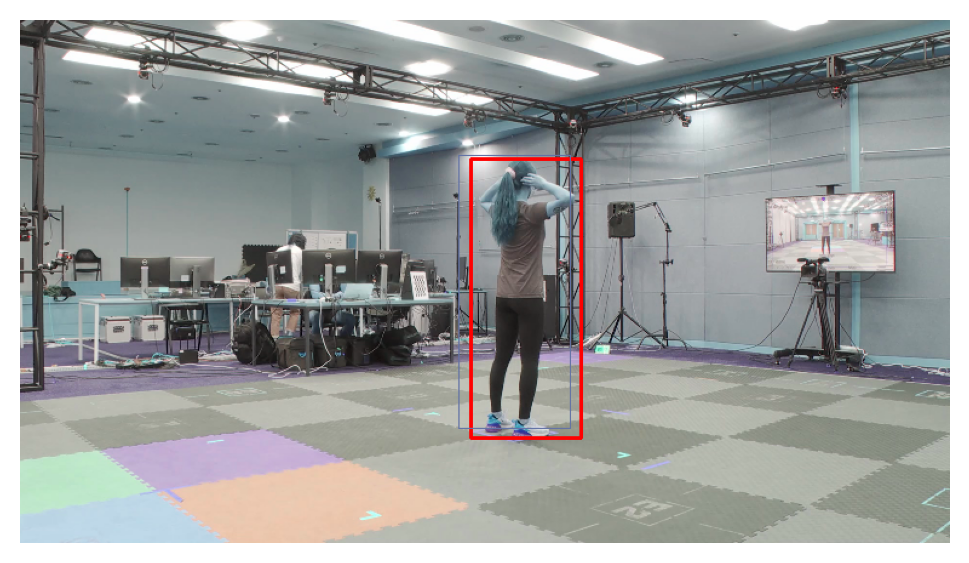

In [50]:
max_output_size = 1
colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(max_output_size)}
x1 = int(ground_truth_row['x_min'])
x2 = int(ground_truth_row['x_max'])
y1 = int(ground_truth_row['y_min'])
y2 = int(ground_truth_row['y_max'])

img_ = image.copy()
cv2.rectangle(img_, (x1, y1), (x2, y2), (255, 0, 0), thickness=2)

selected_indices = tf.image.non_max_suppression(rois, ious, max_output_size=max_output_size, score_threshold=0.01)
anchors = tf.gather(rois, selected_indices)

for i, anchor in enumerate(anchors):
    anchor = anchor_to_coordinate(anchor.numpy())
    cv2.rectangle(
        img_, 
        (int(anchor[0]), int(anchor[2])), (int(anchor[1]), int(anchor[3])), 
        colors.get(i), 
        thickness=1
    )

fig, ax = plt.subplots(dpi=200)
ax.imshow(img_)
ax.axis('off')
plt.show()

In [51]:
scores, rps, _ = rpn(tf.keras.layers.Input(image.shape))

In [52]:
scores

<tf.Tensor 'rpn/cls_out/Reshape:0' shape=(None, 11664, 1) dtype=float32>

In [53]:
rps

<tf.Tensor 'rpn/reg_out/Reshape:0' shape=(None, 11664, 4) dtype=float32>

In [54]:
def anchor_to_coordinate(boxes, size=(432, 768)):    
    x1 = boxes[:, :, 0] - boxes[:, :, 2]/2
    x2 = boxes[:, :, 0] + boxes[:, :, 2]/2
    y1 = boxes[:, :, 1] - boxes[:, :, 3]/2
    y2 = boxes[:, :, 1] + boxes[:, :, 3]/2
    
    x1 = tf.clip_by_value(x1, 0, size[1])
    x2 = tf.clip_by_value(x2, 0, size[1])
    y1 = tf.clip_by_value(y1, 0, size[0])
    y2 = tf.clip_by_value(y2, 0, size[0])
    return tf.stack([x1, x2, y1, y2], axis=-1)

In [55]:
def coordinate_to_anxhor(boxes):
    w = boxes[:, :, 1] - boxes[:, :, 0]
    h = boxes[:, :, 3] - boxes[:, :, 2]
    x = boxes[:, :, 0] + w/2
    y = boxes[:, :, 2] + h/2
    return tf.stack([x, y, w, h], axis=-1)

In [56]:
def get_rois(scores, rps, anchor_boxes):
    batch_size = scores.shape[0]

    gx = anchor_boxes[:, 0] + anchor_boxes[:, 2] * rps[:,:,0]
    gy = anchor_boxes[:, 1] + anchor_boxes[:, 3] * rps[:,:,1]
    gw = anchor_boxes[:, 2] * tf.exp(rps[:, :, 2])
    gh = anchor_boxes[:, 3] * tf.exp(rps[:, :, 3])
    rois = tf.stack([gx, gy, gw, gh], axis=2)
    rois = anchor_to_coordinate(rois)

    orders = tf.argsort(scores, axis=1)[:, ::-1, :]

    n_train_pre_nms = 3000
    orders = orders[:, :n_train_pre_nms]
    rois = tf.reshape(tf.gather(rois, orders, batch_dims=1), (-1, n_train_pre_nms, 4))
    rois = coordinate_to_anxhor(rois)
    return rois

In [82]:
rois = get_rois(scores, rps, anchor_boxes)
rois

<tf.Tensor 'stack_8:0' shape=(None, 3000, 4) dtype=float32>

In [83]:
def IoU(rois, gts):
    box1_area = tf.cast(rois[:, :, 2] * rois[:, :, 2], tf.float64)
    box2_area = tf.cast(gts[:,2] * gts[:,3], tf.float64)
    
    x1 = tf.maximum(tf.cast(rois[:, :, 0] - rois[:, :, 2]/2, tf.float64), tf.cast(tf.expand_dims(gts[:, 0] - gts[:, 2]/2, -1), tf.float64))
    x2 = tf.minimum(tf.cast(rois[:, :, 0] + rois[:, :, 2]/2, tf.float64), tf.cast(tf.expand_dims(gts[:, 0] + gts[:, 2]/2, -1), tf.float64))
    y1 = tf.maximum(tf.cast(rois[:, :, 1] - rois[:, :, 3]/2, tf.float64), tf.cast(tf.expand_dims(gts[:, 1] - gts[:, 3]/2, -1), tf.float64))
    y2 = tf.minimum(tf.cast(rois[:, :, 1] + rois[:, :, 3]/2, tf.float64), tf.cast(tf.expand_dims(gts[:, 1] + gts[:, 3]/2, -1), tf.float64))
    
    h = tf.maximum(tf.constant(0.0, dtype=tf.float64), y2 - y1 + 1.)
    w = tf.maximum(tf.constant(0.0, dtype=tf.float64), x2 - x1 + 1.)
    
    intersect = tf.math.multiply(h, w)
    union = tf.subtract(tf.add(box1_area, tf.expand_dims(box2_area, -1)), intersect)
    return tf.divide(intersect, union)

In [92]:
gts = tf.keras.layers.Input(shape=(4,))
ious = IoU(rois, gts)

## Detector

### Non-Maximum Suppression

In [93]:
def box_regression(boxes, gt):
    x, y, w, h = gt[0], gt[1], gt[2], gt[3]
    tx = (x - boxes[:, 0]) / (boxes[:, 2])
    ty = (y - boxes[:, 1]) / (boxes[:, 3])
    tw = tf.math.log(w / boxes[:, 2]) 
    th = tf.math.log(h / boxes[:, 3]) 
    return tf.transpose(tf.stack([tx, ty, tw, th]))

In [94]:
def NMS(rois, ious, GT, max_output_size=100):
    n_sample = 32
    pos_ratio = 0.25 
    n_pos = n_sample * pos_ratio
    pos_iou_thresh = 0.5 
    batch_size = 16
    if rois.shape[0]:
        batch_size = rois.shape[0]
    
    nmses = []
    for i in range(batch_size):
        selected_indices = tf.image.non_max_suppression(
            rois[i], 
            tf.cast(ious[i], tf.float32), 
            max_output_size=max_output_size, 
            score_threshold=1e-12, 
            iou_threshold=pos_iou_thresh
        )
        selected_anchors = tf.gather(rois[i], selected_indices)
        selected_ious = tf.gather(ious[i], selected_indices)

        pos_indices = tf.squeeze(tf.where(selected_ious >= pos_iou_thresh), -1)
        pos_anchors = tf.gather(selected_anchors, pos_indices) 

        neg_indices =tf.squeeze(tf.where(selected_ious < pos_iou_thresh), -1)
        neg_anchors = tf.gather(selected_anchors, neg_indices)
        
        labels = tf.reshape(tf.concat([tf.ones_like(pos_anchors)[:,0], tf.zeros_like(neg_anchors)[:,0]], axis=0)[:32], (-1, 1))
        nms = tf.concat([pos_anchors, neg_anchors], axis=0)[:32]
#         nms = box_regression(nms, GT[i])
        nms = tf.concat([nms, labels], axis=-1)
        nmses.append(nms)
    
    return tf.stack(nmses, axis=0)

In [143]:
nms = NMS(rois, ious, GT)
nms

<tf.Tensor 'stack_11:0' shape=(16, None, 5) dtype=float32>

### Regional Interest Projection

### RoI pooling

In [ ]:
def anchor_to_anchor(boxes):    
    x1 = boxes[:, :, 0] - boxes[:, :, 2]/2
    y1 = boxes[:, :, 1] - boxes[:, :, 3]/2
    return tf.stack([y1, x1, boxes[:, :, 3], boxes[:, :, 2]], axis=-1)

In [ ]:
def projection(nmses, feature_map):
    roi_projections_tensor = []
    for i in range(2):
        roi_projections = []
        for j in range(32):
            y, x, h, w = nmses[i, j]
            roi_projection = tf.image.crop_to_bounding_box(feature_map[i], y, x, h, w)
            roi_projection = tf.image.resize(roi_projection, size=(7, 13))
            roi_projections.append(roi_projection)
        roi_projections_tensor.append(tf.stack(roi_projections, axis=0))
    return tf.stack(roi_projections_tensor, axis=0)

In [ ]:
def box_regression(boxes, gt):
    boxes = tf.cast(boxes, tf.float64)
    gt = tf.cast(gt, tf.float64)

    x = tf.reshape(gt[:, 0], (-1, 1))
    y = tf.reshape(gt[:, 1], (-1, 1))
    w = tf.reshape(gt[:, 2], (-1, 1))
    h = tf.reshape(gt[:, 3], (-1, 1))

    # x, y, w, h = gt[:, 0], gt[:, 1], gt[:, 2], gt[:, 3]
    tx = (x - boxes[:, :, 0]) / (boxes[:, :, 2])
    ty = (y - boxes[:, :, 1]) / (boxes[:, :, 3])
    tw = tf.math.log(w / boxes[:, :, 2]) 
    th = tf.math.log(h / boxes[:, :, 3]) 
    return tf.stack([tx, ty, tw, th], -1)

In [ ]:
def NMS(rois, ious, GT, feature_map):
    n_sample = 32
    pos_ratio = 0.25 
    n_pos = n_sample * pos_ratio
    pos_iou_thresh = 0.5 
    
    batch_size = 16
    if rois.shape[0]:
        batch_size = rois.shape[0]

    nmses = []
    for i in range(batch_size):
        selected_indices = tf.image.non_max_suppression(
            rois[i], 
            tf.cast(ious[i], tf.float32), 
            max_output_size=100, 
            iou_threshold=pos_iou_thresh
        )
        selected_anchors = tf.gather(rois[i], selected_indices)
        selected_ious = tf.gather(ious[i], selected_indices)

        pos_indices = tf.squeeze(tf.where(selected_ious >= pos_iou_thresh), -1)
        pos_anchors = tf.gather(selected_anchors, pos_indices) 

        neg_indices =tf.squeeze(tf.where(selected_ious < pos_iou_thresh), -1)
        neg_anchors = tf.gather(selected_anchors, neg_indices)
        
        labels = tf.reshape(tf.concat([tf.ones_like(pos_anchors)[:,0], tf.zeros_like(neg_anchors)[:,0]], axis=0)[:32], (-1, 1))
        nms = tf.concat([pos_anchors, neg_anchors], axis=0)[:32]
        nms = tf.concat([nms, labels], axis=-1)
        nmses.append(nms)

    nmses = tf.stack(nmses, axis=0)
    labels = tf.expand_dims(nmses[:, :, -1], -1)
    nmses = nmses[:, :, :4]

    nmss = tf.cast(anchor_to_anchor(nmses)//2**4, tf.int32)
    roi_projections_tensor = projection(nmss, feature_map)
    bboxes_reg = box_regression(nmses, gts)

    return roi_projections_tensor, bboxes_reg, labels

In [ ]:
feature_map = rpn.base_model(inputs)
roi_projections_tensor, bboxes_reg_labels, labels = NMS(rois, ious, gts, feature_map)

##  Classifier Network

### Label Generating

### Classifier 

In [ ]:
class Classifier(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super(Classifier, self).__init__(**kwargs)
        self.fconv = tf.keras.layers.Conv2D(2048, 7, 13)
        self.reshape = tf.keras.layers.Reshape((-1,))
        self.dense1 = tf.keras.layers.Dense(2048)
        self.dense2a = tf.keras.layers.Dense(1, activation='sigmoid')
        self.dense2b = tf.keras.layers.Dense(4)
        
    def compile(self, optimizer):
        super(Classifier, self).compile()
        self.optimizer = optimizer
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        self.test_loss_tracker = tf.keras.metrics.Mean(name='test_loss')
    
    def Cls_Loss(self, y_true, y_pred):
        return tf.losses.BinaryCrossentropy()(y_true, y_pred)

    def Reg_Loss(self, y_true, y_pred, indices):
        return tf.reduce_mean(tf.losses.Huber(reduction=tf.losses.Reduction.NONE)(y_true[indices], y_pred[indices]), axis=-1)
    
    def train_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        indices = tf.reduce_any(tf.not_equal(y_cls, 0), axis=-1)
        rpn_lambda = 10
        
        with tf.GradientTape() as tape:
            cls, bbox_reg = self(x, training=True)
            cls_loss = self.Cls_Loss(y_cls, cls)
            reg_loss = self.Reg_Loss(y_reg, bbox_reg, indices)
            losses = cls_loss + rpn_lambda * reg_loss
            
        trainable_vars = self.trainable_variables
        grad = tape.gradient(losses, trainable_vars)
        self.optimizer.apply_gradients(zip(grad, trainable_vars))
        self.loss_tracker.update_state(losses)
        return {'classifier_loss': self.loss_tracker.result()}

    def test_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        rpn_lambda = 5
        
        cls, bbox_reg, _ = self(x, training=False)
        cls_loss = self.Cls_Loss(y_cls, cls)
        reg_loss = self.Reg_Loss(y_reg, bbox_reg)
        losses = cls_loss + rpn_lambda * reg_loss

        self.test_loss_tracker.update_state(losses)
        return {'classifier_loss_val': self.test_loss_tracker.result()}

    def call(self, inputs, ):
        x = tf.keras.layers.TimeDistributed(self.fconv)(inputs)
        x = tf.keras.layers.TimeDistributed(self.reshape)(x)
        feature_vector = tf.keras.layers.TimeDistributed(self.dense1)(x)
        cls = tf.keras.layers.TimeDistributed(self.dense2a)(feature_vector)
        bbox = tf.keras.layers.TimeDistributed(self.dense2b)(feature_vector)
        return cls, bbox

In [ ]:
classifier = Classifier()

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001)
)

In [ ]:
history = classifier.fit(
    x = roi_projections_tensor,
    y = (bboxes_reg, labels),
    epochs=5
)

## Faster R-CNN

In [ ]:
class Faster_RCNN(tf.kersa.Model):
    def __init__(self, anchor_boxes, **kwargs):
        super(Faster_RCNN, self).__init__(*kwargs)
        self.anchor_boxes = anchor_boxes
        self.rpn = RPN()
        self.roipooling = RoIPooling()
        self.classifier = Classifier()
        self.rpn_train = False
        self.classifier_train = False

    def compile(self, rpn_optimizer, classifier_optimizer):
        super(Faster_RCNN, self).compile()
        self.rpn.optimizer = optimizer
        self.classifier.optimizer = optimizer
        
    def train_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        
        if self.rpn_train:
            self.classifier.trainable = False
            self.rpn.trainable = True
            result = self.rpn.train_step(x, (y_cls, y_reg))
            
        if self.classifier_train:
            self.classifier.trainable = True
            self.rpn.trainable = False
            scores, bboxes = self(x)
            result = self.classifier.train_step(x, (y_cls, y_reg))
        return result
    
    def test_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        rpn_lambda = 5
        
        cls, bbox_reg, _ = self(x, training=False)
        cls_loss = self.Cls_Loss(y_cls, cls)
        reg_loss = self.Reg_Loss(y_reg, bbox_reg)
        losses = cls_loss + rpn_lambda * reg_loss

        self.test_loss_tracker.update_state(losses)
        return {'classifier_loss_val': self.test_loss_tracker.result()}
    
    def call(self, inputs, gts):
        scores, rps, feature_map = self.rpn(inputs)
        rois = get_rois(scores, rps, self.anchor_boxes)
        ious = IoU(rois, gts)
        roi_projections_tensor, bboxes_reg_labels, labels = NMS(rois, ious, gts, feature_map)
        scores, bboxes = self.classifier(roi_projections_tensor)
        return scores, bboxes